In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, multinomial
from scipy.special import comb
import scipy.stats as stats
import statsmodels as sm
import math

In [5]:
# The idea here is that there may be multiple rare variants that cause the disease

-6.7142850413442225 0.020000337093570988
P[D|novar]= 0.0012119825865446693
-4.801630108909671 0.02000027797610837
P[D|novar]= 0.008149384458722764
-4.460565540694136 0.020000212436733784
P[D|novar]= 0.011423814534471223
-4.200704078746762 0.02000060252579127
P[D|novar]= 0.01476378679270214
-4.016181253118483 0.020000083475520788
P[D|novar]= 0.01770262328873604
-4.001983215578705 0.02000003383987052
P[D|novar]= 0.017951214472929394
-4.801630108909671 0.02000027797610837
P[D|novar]= 0.008149384458722764
-6.728912346669705 0.02000012021920563
P[D|novar]= 0.00119440459439449
-5.540875386452104 0.010000202812242277
P[D|novar]= 0.003907760612984114
-2.9226674952885197 0.10000044391850033
P[D|novar]= 0.051044335766164316
-0.33004393512301744 0.5000003931364697
P[D|novar]= 0.4182299331043454
-4.801630108909671 0.02000027797610837
P[D|novar]= 0.008149384458722764
-7.888046961262595 0.020000331299697388
P[D|novar]= 0.0003750609197447207
-11.24740269921367 0.020000548639277565
P[D|novar]= 1.30409

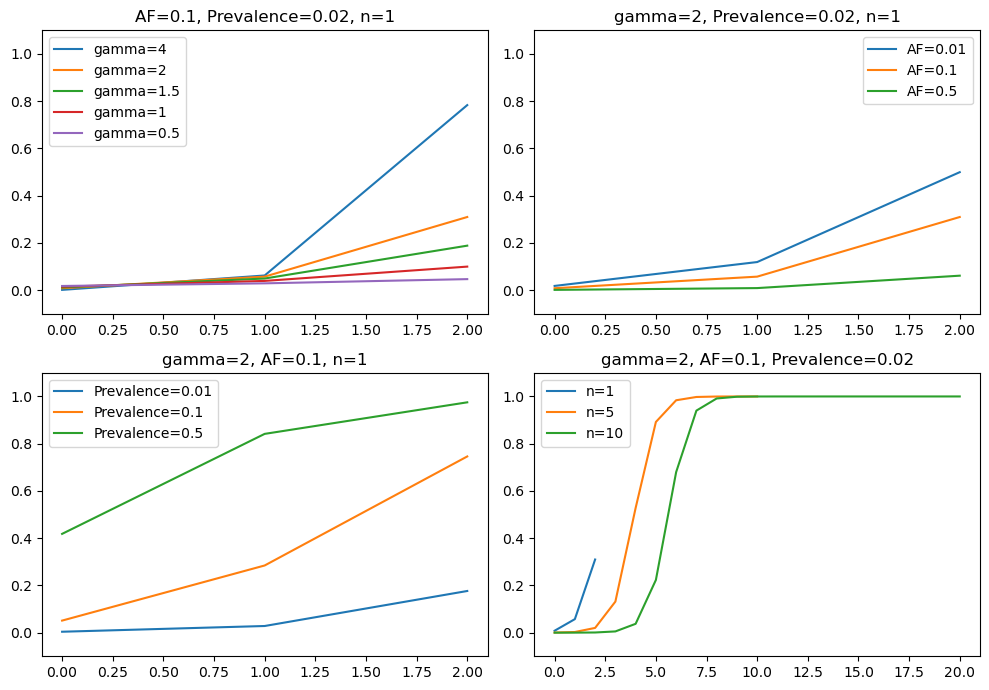

In [170]:
# Genetic Relative Risk

# if you have one of the rare variants, your chance of getting D is gamma-times more than usual
# this doesn't work as we consider multiple variants (and actually doesn't work in the original case if cgamma^2>1)


class P_D():
    def __init__(self, gamma, n, prevalence, af):
        self.gamma = gamma
        self.n = n
        self.p = prevalence
        self.a = af
        self.x = np.arange(2*self.n+1)
        
        # chose x_0 to get desired overall disease prevalence
        var_p = binom.pmf(self.x, 2*self.n, self.a)
        self.x_0 = 0
        rr = self()
        while np.abs(np.sum(var_p*rr)-self.p)>10**-6:
        #for _ in range(10):
            f_x = np.sum(var_p*rr)-self.p
            #f_prime_x = f_x-1
            f_prime_x = np.sum(var_p*rr*(1-var_p*rr))
            #f_prime_x = np.sum(-self.gamma*var_p*np.exp(-self.gamma*np.clip(self.x-self.x_0, 0.01, None)))
            self.x_0 = self.x_0 - f_x/f_prime_x
            rr = self()
        print(self.x_0, np.sum(var_p*rr))
        print('P[D|novar]=', self()[0])
        self.p = np.sum(var_p*rr)
        
    def __call__(self):
        return 1/(1+np.exp(-self.gamma*self.x-self.x_0))
        #return 1-np.exp(-self.gamma*(np.clip(self.x-self.x_0, 0.01, None)))

gamma, n, p = 2, 1, 0.02

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.plot(np.arange(2*n+1), P_D(4, n, p, 0.1)(), label='gamma=4')
plt.plot(np.arange(2*n+1), P_D(2, n, p, 0.1)(), label='gamma=2')
plt.plot(np.arange(2*n+1), P_D(1.5, n, p, 0.1)(), label='gamma=1.5')
plt.plot(np.arange(2*n+1), P_D(1, n, p, 0.1)(), label='gamma=1')
plt.plot(np.arange(2*n+1), P_D(0.5, n, p, 0.1)(), label='gamma=0.5')
plt.title('AF=0.1, Prevalence=0.02, n=1')
plt.ylim([-0.1, 1.1])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.arange(2*n+1), P_D(gamma, n, p, 0.01)(), label='AF=0.01')
plt.plot(np.arange(2*n+1), P_D(gamma, n, p, 0.1)(), label='AF=0.1')
plt.plot(np.arange(2*n+1), P_D(gamma, n, p, 0.5)(), label='AF=0.5')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, Prevalence=0.02, n=1')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.arange(2*n+1), P_D(gamma, n, 0.01, 0.1)(), label='Prevalence=0.01')
plt.plot(np.arange(2*n+1), P_D(gamma, n, 0.1, 0.1)(), label='Prevalence=0.1')
plt.plot(np.arange(2*n+1), P_D(gamma, n, 0.5, 0.1)(), label='Prevalence=0.5')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, AF=0.1, n=1')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(np.arange(2*1+1), P_D(gamma, 1, p, 0.1)(), label='n=1')
plt.plot(np.arange(2*5+1), P_D(gamma, 5, p, 0.1)(), label='n=5')
plt.plot(np.arange(2*10+1), P_D(gamma, 10, p, 0.1)(), label='n=10')
plt.ylim([-0.1, 1.1])
plt.title('gamma=2, AF=0.1, Prevalence=0.02')
plt.legend()

plt.tight_layout()

plt.show()

In [149]:
def assoc_power_simulation(p_d, num_samples, num_trials=10000):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    gamma = p_d.gamma
    
    # What's the probability of having variants at other sites?
    var_p = binom.pmf(np.arange(2*(n-1)+1), 2*(n-1), a)
    
    rr = p_d()
    
    p_g2_givD = np.sum(var_p*rr[2:])*a**2/p
    p_g1_givD = np.sum(var_p*rr[1:-1])*2*a*(1-a)/p
    p_g0_givD = np.sum(var_p*rr[:-2])*(1-a)**2/p
    
    # and P[G_this_site=x|~D] = P[~D|G=x]*P[G=x]/P[~D]
    p_g2_givnoD = (1-np.sum(var_p*rr[2:]))*a**2/(1-p)
    p_g1_givnoD = (1-np.sum(var_p*rr[1:-1]))*2*a*(1-a)/(1-p)
    p_g0_givnoD = (1-np.sum(var_p*rr[:-2]))*(1-a)**2/(1-p)
    
    gencounts_D = np.random.multinomial(num_samples, [p_g0_givD, p_g1_givD, p_g2_givD], size=num_trials)
    gencounts_noD = np.random.multinomial(num_samples, [p_g0_givnoD, p_g1_givnoD, p_g2_givnoD], size=num_trials)
    
    allelecount_D = gencounts_D[:, 1]+2*gencounts_D[:, 2]
    allelecount_noD = gencounts_noD[:, 1]+2*gencounts_noD[:, 2]
    
    has_data = allelecount_D+allelecount_noD>0
    power = np.sum(stats.hypergeom.sf(allelecount_D[has_data], 4*num_samples, (allelecount_D+allelecount_noD)[has_data], 2*num_samples)<=0.05)/num_trials
    return power

    
def num_samples_by_power_simulation(p_d, power_f, power=0.9):
    min_sample_size = 1
    min_power = power_f(p_d, min_sample_size)
    max_sample_size, max_power = None, None
        
    while max_power is None:
    #for _ in range(10):
        current_sample_size = min_sample_size*10
        if current_sample_size>10**9:
            return None, None
        
        current_power = power_f(p_d, current_sample_size)
        #print('find max', current_sample_size, current_power)
        if current_power > power:
            max_sample_size, max_power = current_sample_size, current_power
        elif current_power < power:
            min_sample_size, min_power = current_sample_size, current_power
        else:
            max_sample_size, max_power = current_sample_size, current_power
            min_sample_size, min_power = current_sample_size, current_power
            
    while max_sample_size - min_sample_size > 1:
    #for _ in range(10):
        current_sample_size = int(math.floor((max_sample_size - min_sample_size)/2)+min_sample_size)
        current_power = power_f(p_d, current_sample_size)
        #print('find', min_sample_size, max_sample_size, current_sample_size, current_power)
        if current_power > power:
            max_sample_size, max_power = current_sample_size, current_power
        elif current_power < power:
            min_sample_size, min_power = current_sample_size, current_power
        else:
            max_sample_size, max_power = current_sample_size, current_power
            min_sample_size, min_power = current_sample_size, current_power
    return max_sample_size, max_power
        
    
#power_by_simulation_assoc(P_D(gamma, n, p, 0.1), 100)
num_samples_by_simulation_assoc(P_D(gamma, 1, p, 0.01), assoc_power_simulation)


2.000966899050048 0.020000991517848284
P[D|novar]= 0.017952085672850036


(69, 0.9024)

In [98]:
# Power for association test
def get_samples_assoc(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    gamma = p_d.gamma
    
    tind_power = sm.stats.power.TTestIndPower()
    
    # What's the probability of having variants at other sites?
    var_p = binom.pmf(np.arange(2*(n-1)+1), 2*(n-1), a)
    
    rr = p_d()
    #print('rr', rr)
    
    # now we want P[G_this_site=x|D] = P[D|G=x]*P[G=x]/P[D]
    p_g2_givD = np.sum(var_p*rr[2:])*a**2/p
    p_g1_givD = np.sum(var_p*rr[1:-1])*2*a*(1-a)/p
    p_g0_givD = np.sum(var_p*rr[:-2])*(1-a)**2/p
    print('p_givD', p_g0_givD, p_g1_givD, p_g2_givD)
    
    # and P[G_this_site=x|~D] = P[~D|G=x]*P[G=x]/P[~D]
    p_g2_givnoD = (1-np.sum(var_p*rr[2:]))*a**2/(1-p)
    p_g1_givnoD = (1-np.sum(var_p*rr[1:-1]))*2*a*(1-a)/(1-p)
    p_g0_givnoD = (1-np.sum(var_p*rr[:-2]))*(1-a)**2/(1-p)
    print('p_givnoD', p_g0_givnoD, p_g1_givnoD, p_g2_givnoD)

    m1 = 2*p_g2_givD + p_g1_givD # E[G|D]
    m2 = 2*p_g2_givnoD + p_g1_givnoD # E[G|~D]
    std1 = np.sqrt(p_g2_givD*(2-m1)**2 + p_g1_givD*(1-m1)**2) + p_g0_givD*m1**2
    std2 = np.sqrt(p_g2_givnoD*(2-m2)**2 + p_g1_givnoD*(1-m2)**2 + p_g0_givnoD*m2**2)
    print(m1, m2, std1, std2)
    return tind_power.solve_power(abs(m1-m2)/max(std1, std2), nobs1=None, alpha=0.05, power=0.9, ratio=1)




In [126]:
def concordant_sibpair_power_simulation(p_d, num_samples, num_trials=10000):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    
    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=2|IBD=2]
    p_D2_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2])
        
    # P[D=2|IBD=1]
    p_D2_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2])
    
    # P[D=2|IBD=0]
    p_D2_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*rr[vars_sib2]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*rr[vars_sib2])
            
    p_D2 = p_D2_givIBD2*0.25 + p_D2_givIBD1*0.5 + p_D2_givIBD0*0.25

    p_IBD2_givD2 = p_D2_givIBD2*0.25/p_D2
    p_IBD1_givD2 = p_D2_givIBD1*0.5/p_D2
    p_IBD0_givD2 = p_D2_givIBD0*0.25/p_D2
    
    ibd = np.random.multinomial(num_samples, [p_IBD0_givD2, p_IBD1_givD2, p_IBD2_givD2], size=num_trials)
    
    power = np.sum(stats.binom.sf(ibd[:, 1]+2*ibd[:, 2], 2*num_samples, 0.5)<=0.05)/num_trials
    return power

In [125]:


# Power for sibpair test
def get_samples_sibpair_concordant(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    
    t_power = sm.stats.power.TTestPower()

    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=2|IBD=2]
    p_D2_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2])
        
    # P[D=2|IBD=1]
    p_D2_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2])
    
    # P[D=2|IBD=0]
    p_D2_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*rr[vars_sib2+2]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*rr[vars_sib2+1]) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*rr[vars_sib2+2]) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*rr[vars_sib2+1]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*rr[vars_sib2]) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*rr[vars_sib2+2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*rr[vars_sib2]) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*rr[vars_sib2+1]) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*rr[vars_sib2])
            
    p_D2 = p_D2_givIBD2*0.25 + p_D2_givIBD1*0.5 + p_D2_givIBD0*0.25
    print('prob of aff-aff sibpair', p_D2, p**2)

    p_IBD2_givD2 = p_D2_givIBD2*0.25/p_D2
    p_IBD1_givD2 = p_D2_givIBD1*0.5/p_D2
    p_IBD0_givD2 = p_D2_givIBD0*0.25/p_D2
    
    print(p_IBD2_givD2, p_IBD1_givD2, p_IBD0_givD2)
    
    m = 2*p_IBD2_givD2 + p_IBD1_givD2
    std = np.sqrt(p_IBD2_givD2*(2-m)**2 + p_IBD1_givD2*(1-m)**2 + p_IBD0_givD2*m**2)
    print('m', m, std, np.sqrt(0.5))

    return t_power.solve_power(abs(m-1)/np.sqrt(0.5), nobs=None, alpha=0.05, power=0.9)


In [159]:
def discordant_sibpair_power_simulation(p_d, num_samples, num_trials=10000):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    print(options.shape)
    
    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=1|IBD=2]
    p_D1_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
        
    # P[D=1|IBD=1]
    p_D1_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
    
    # P[D=1|IBD=0]
    p_D1_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
            
    p_D1 = p_D1_givIBD2*0.25 + p_D1_givIBD1*0.5 + p_D1_givIBD0*0.25
    print('prob of aff-unaff sibpair', p_D1, p*(1-p))

    p_IBD2_givD1 = p_D1_givIBD2*0.25/p_D1
    p_IBD1_givD1 = p_D1_givIBD1*0.5/p_D1
    p_IBD0_givD1 = p_D1_givIBD0*0.25/p_D1
    
    ibd = np.random.multinomial(num_samples, [p_IBD0_givD1, p_IBD1_givD1, p_IBD2_givD1], size=num_trials)
    
    power = np.sum(stats.binom.cdf(ibd[:, 1]+2*ibd[:, 2], 2*num_samples, 0.5)<=0.05)/num_trials
    return power

In [156]:


# Power for sibpair test
def get_samples_sibpair_discordant(p_d):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    gamma = p_d.gamma
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    print(options.shape)
    
    t_power = sm.stats.power.TTestPower()

    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
                                      0.5*a*(1-a), # child1 inherits a variant, but not child2
                                      0.5*a*(1-a), # child2 inherits a variant, but not child1
                                      0.5*a*(1-a) + (1-a)**2]) # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=1|IBD=2]
    p_D1_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
        
    # P[D=1|IBD=1]
    p_D1_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
    
    # P[D=1|IBD=0]
    p_D1_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
            
    p_D1 = p_D1_givIBD2*0.25 + p_D1_givIBD1*0.5 + p_D1_givIBD0*0.25
    print('prob of aff-unaff sibpair', p_D1, p*(1-p))

    p_IBD2_givD1 = p_D1_givIBD2*0.25/p_D1
    p_IBD1_givD1 = p_D1_givIBD1*0.5/p_D1
    p_IBD0_givD1 = p_D1_givIBD0*0.25/p_D1
    
    m = 2*p_IBD2_givD1 + p_IBD1_givD1
    std = np.sqrt(p_IBD2_givD1*(2-m)**2 + p_IBD1_givD1*(1-m)**2 + p_IBD0_givD1*m**2)
    print('m', m, std, np.sqrt(0.5))

    return t_power.solve_power(abs(m-1)/np.sqrt(0.5), nobs=None, alpha=0.05, power=0.9)


In [ ]:
def unaff_sibpair_power_simulation(p_d, num_samples, num_trials=10000):
    a = p_d.a
    n = p_d.n
    p = p_d.p
    
    options = np.zeros(((2*(n-1)+1)**3, 4), dtype=int)
    options[:, 0] = np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 1] = np.tile(np.repeat(np.arange(2*(n-1)+1), (2*(n-1)+1)), 2*(n-1)+1)
    options[:, 2] = np.tile(np.arange(2*(n-1)+1), (2*(n-1)+1)**2)
    options[:, 3] = 2*(n-1) - np.sum(options, axis=1)
    options = options[options[:, -1]>=0, :]
    print(options.shape)
    
    # What's the probability of having variants at other sites?
    var_p = multinomial.pmf(options, n=2*(n-1), p=[
        a**2 + 2*a*(1-a)/8, # variants: aff, unaff1, unaff2
        2*a*(1-a)/8, # variants: aff, unaff1
        2*a*(1-a)/8, # variants: aff, unaff2
        2*a*(1-a)/8, # variants: aff
        2*a*(1-a)/8, # variants: unaff1, unaff2
        2*a*(1-a)/8, # variants: unaff1
        2*a*(1-a)/8, # variants: unaff2
        (1-a)**2 + 2*a*(1-a)/8 # no child inherits a variant

        
        a**2+0.5*a*(1-a), # both children inherit a variant (either parent has 2 or parent has 1 and both children inherit it)
        0.5*a*(1-a), # child1 inherits a variant, but not child2
        0.5*a*(1-a), # child2 inherits a variant, but not child1
        0.5*a*(1-a) + (1-a)**2 # neither children inherit a variant (either parent has 0 or parent has 1 and neither child inherits it)
    ]) 
    
    if n==1:
        var_p = np.array([1])
        
    rr = p_d()

    vars_sib1 = options[:, 0]+options[:, 1]
    vars_sib2 = options[:, 0]+options[:, 2]
        
    # P[D=1|IBD=2]
    p_D1_givIBD2 = np.sum(a**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
        
    # P[D=1|IBD=1]
    p_D1_givIBD1 = np.sum(a**3*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(a*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)*a**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum((1-a)**2*a*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
    
    # P[D=1|IBD=0]
    p_D1_givIBD0 = np.sum(a**4*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2+1])) + \
                   np.sum(2*a**3*(1-a)*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+2])) + \
                   np.sum(4*a**2*(1-a)**2*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2+1])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1+2]*(1-rr[vars_sib2])) + \
                   np.sum(a**2*(1-a)**2*var_p*rr[vars_sib1]*(1-rr[vars_sib2+2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1+1]*(1-rr[vars_sib2])) + \
                   np.sum(2*a*(1-a)**3*var_p*rr[vars_sib1]*(1-rr[vars_sib2+1])) + \
                   np.sum((1-a)**4*var_p*rr[vars_sib1]*(1-rr[vars_sib2]))
            
    p_D1 = p_D1_givIBD2*0.25 + p_D1_givIBD1*0.5 + p_D1_givIBD0*0.25
    print('prob of aff-unaff sibpair', p_D1, p*(1-p))

    p_IBD2_givD1 = p_D1_givIBD2*0.25/p_D1
    p_IBD1_givD1 = p_D1_givIBD1*0.5/p_D1
    p_IBD0_givD1 = p_D1_givIBD0*0.25/p_D1
    
    ibd = np.random.multinomial(num_samples, [p_IBD0_givD1, p_IBD1_givD1, p_IBD2_givD1], size=num_trials)
    
    power = np.sum(stats.binom.cdf(ibd[:, 1]+2*ibd[:, 2], 2*num_samples, 0.5)<=0.05)/num_trials
    return power

In [164]:
n = 10
gamma = 1 # GRR
p = 0.02 # disease prevalence

bins_a = np.hstack((10.0**np.arange(-5, 0, 0.5), [0.5]))

samples_assoc = np.zeros((len(bins_a),))
samples_sibpair_con = np.zeros((len(bins_a),))
samples_sibpair_dis = np.zeros((len(bins_a),))

for i in range(len(bins_a)):
    print('AF', bins_a[i])
    p_d = P_D(gamma, n, p, bins_a[i])
    
    samples_assoc[i] = num_samples_by_power_simulation(p_d, assoc_power_simulation)[0]
    samples_sibpair_con[i] = num_samples_by_power_simulation(p_d, concordant_sibpair_power_simulation)[0]
    samples_sibpair_dis[i] = num_samples_by_power_simulation(p_d, discordant_sibpair_power_simulation)[0]

AF 1e-05
3.8921023732135276 0.020000983125300634
P[D|novar]= 0.019994472076478798
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[0 2 1 ... 2 1 2] 2
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[11 11 12 ... 12  9 10] 20
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[105  94 104 ...  98  92 108] 200
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[ 975  996  979 ... 1001  994 1009] 2000
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[10066  9949  9988 ... 10119  9912 10128] 20000
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[ 99775 100386 100107 ... 100014  99966  99906] 200000
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[1000464 1000269  998775 ... 1000374 1000932  999507] 2000000
(1330, 4)
prob of aff-unaff sibpair 0.019600837777575 0.019600943799322073
[10002702 10003857 10000957 ...

(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[578050890 578039341 578086938 ... 578062590 578056812 578106764] 1156250000
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[563994811 564046173 564019353 ... 564018905 564020559 564030423] 1128125000
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[556986889 556982758 556980844 ... 556947635 556974307 556945408] 1114062500
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[553469689 553473975 553437712 ... 553456921 553473751 553432463] 1107031250
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[555222757 555221162 555236438 ... 555221205 555223785 555222690] 1110546874
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[554318086 554307783 554354667 ... 554326981 554319700 554364521] 1108789062
(1330, 4)
prob of aff-unaff sibpair 0.01956742434370995 0.01960094589937506
[55479

(1330, 4)
prob of aff-unaff sibpair 0.01949579839370242 0.0196009421108681
[50197596 50194935 50196681 ... 50187535 50187370 50185226] 100414246
AF 0.03162277660168379
4.899480664757194 0.020000994151721185
P[D|novar]= 0.0073953526333326094
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[0 1 0 ... 0 1 1] 2
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[10 13 12 ...  7 11  3] 20
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[103  97  98 ...  96 101  99] 200
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[ 974 1020 1017 ... 1009  993  990] 2000
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[ 9989 10096  9906 ... 10013 10038 10057] 20000
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[ 99936  99895 100169 ...  99816  99684 100101] 200000
(1330, 4)
prob of aff-unaff sibpair 0.019288475167035725 0.019600954384664
[999705 9

[190359 190589 190907 ... 191213 191008 191001] 382812
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[194254 193802 193910 ... 194035 193780 194205] 389842
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[192500 192085 191805 ... 192831 192438 192519] 386326
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[191692 191731 191635 ... 191381 191547 190997] 384568
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[190825 191209 190605 ... 190399 191419 190872] 383690
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[190707 190814 191443 ... 191388 191030 191497] 384128
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[190537 190882 190806 ... 190541 191548 191139] 383908
(1330, 4)
prob of aff-unaff sibpair 0.01844547001055154 0.019599044632758852
[190769 191288 191096 ... 191127 190966 190776] 383798
(1330, 4)
prob of aff

[1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 5.00000000e-01]


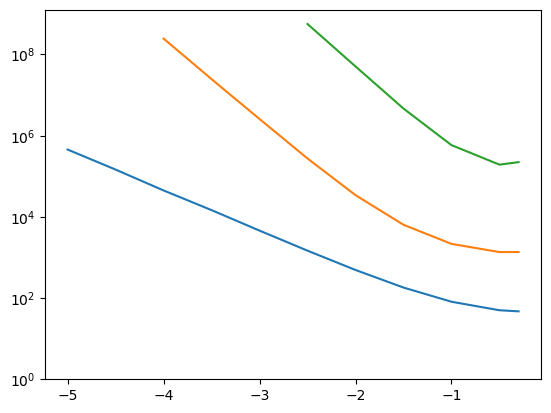

In [165]:
print(bins_a)
plt.plot(np.log10(bins_a), np.log10(samples_assoc))
plt.plot(np.log10(bins_a), np.log10(samples_sibpair_con))
plt.plot(np.log10(bins_a), np.log10(samples_sibpair_dis))
#plt.xticks(np.arange(-5, 0), ['$10^{%d}$' % i for i in np.arange(-5, 0)])
plt.yticks(np.arange(0, 10, 2), ['$10^{%d}$' % i for i in np.arange(0, 10, 2)])
plt.show()

In [103]:
print(samples_sibpair_con)

[2.18717679e+05 6.91429023e+04 2.18437269e+04 6.88740164e+03
 2.15975658e+03 6.69082960e+02 2.19755164e+02 1.55012058e+02
 1.09729004e+02 8.41909677e+01 7.00660176e+01]


In [104]:
print(samples_assoc)

[24698.  8034.  2463.   797.   247.    79.    32.    58.    54.    53.
    51.]


In [ ]:
print(samples_assoc)